In [15]:

import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader, Dataset
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from asteroid.metrics import get_metrics
from asteroid.losses import singlesrc_neg_sisdr, singlesrc_neg_snr

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from IPython.display import Audio
from tqdm import tqdm
import time



def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple([torch.linspace(-1, 1, steps=sidelen[0])] + [torch.linspace(-1, 1, steps=sidelen[1])])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid
    
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = {}

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations


class AudioFile(torch.utils.data.Dataset):
    def __init__(self, filename):
        self.data, self.rate = torchaudio.load(filename)
        self.data = self.data.transpose(-1,-2).numpy()[...,0]
        self.data = torch.from_numpy(self.data.astype(np.float32))
        self.data = torch.stft(self.data, 1024, return_complex=False)
        self.shape = self.data.shape[:2]
        self.timepoints = get_mgrid(self.shape, 2)
    
    def get_shape(self):
        return self.shape
    
    def get_num_samples(self):
        return self.timepoints.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.timepoints, self.data
    
def reconstruct_shape(model_output, shape):
    return model_output.view([*shape] + [2]).unsqueeze(0)

    
def spectrogram(wav):
    stft = torchaudio.transforms.Spectrogram(n_fft=1024)(wav)[0]
    stft = torchaudio.transforms.AmplitudeToDB(top_db=80)(stft).numpy()
    stft = stft[::-1]
    fig = plt.figure(figsize=(20,10))
    im = plt.imshow(stft)
    plt.colorbar(im)

# bit = torchaudio.backend.sox_io_backend.info(os.path.join(datapath, 'all_mono.wav')).bits_per_sample
datapath = '/root/bigdatasets/INRcompression'
    
audio, rate = torchaudio.load(os.path.join(datapath, 'all_mono.wav'))
# for idx, i in enumerate(range(0, audio.shape[-1], rate * 10)):
#     torchaudio.save(os.path.join(datapath, f'all_mono_{idx}.wav'), audio[:, i:i+rate*10], sample_rate=rate)

wavpath = sorted(glob(os.path.join(datapath, f'all_mono_*.wav')), key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))
    
    
total_steps = 2000
steps_til_summary = 1000

pesq = []
for wave in wavpath:
    bach_audio = AudioFile(wave)
    shape = bach_audio.get_shape()

    audio_siren = Siren(in_features=2, out_features=2, hidden_features=256, 
                        hidden_layers=3, first_omega_0=3000, outermost_linear=True)
    audio_siren.cuda()
    dataloader = DataLoader(bach_audio, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
    
    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

    model_input, ground_truth, audio_siren = model_input.type(torch.float64), \
                                            ground_truth.type(torch.float64), \
                                             audio_siren.type(torch.float64)
    optim = torch.optim.Adam(lr=1e-4, params=audio_siren.parameters())

    with tqdm(range(total_steps)) as pbar:
        for step in pbar:
            optim.zero_grad()
            model_output, coords = audio_siren(model_input)
            loss = F.mse_loss(model_output, ground_truth.reshape(1, -1, ground_truth.shape[-1]))
            
            pbar.set_postfix({'loss': loss.item()})
            model_output = model_output.view([1]+[*shape]+[2])
            loss.backward()
            optim.step()
    
    audio_siren.eval()
    with torch.no_grad():
        model_output, _ = audio_siren(model_input)
    model_output = torch.istft(torch.complex(model_output[...,0], model_output[...,1]).view([1]+[*shape]), 1024)
    ground_truth = torch.istft(torch.complex(ground_truth[...,0], ground_truth[...,1]), 1024)
    model_output = model_output.float()
    ground_truth = ground_truth.float()
    torchaudio.save(os.path.join(datapath, 'mse_stft_recons' + os.path.basename(wave)), model_output.squeeze(-1).cpu().float(), sample_rate=rate)
    model_output = torchaudio.functional.resample(model_output.squeeze(-1), rate, 16000).squeeze().cpu()
    model_input = torchaudio.functional.resample(model_input.squeeze(-1), rate, 16000).squeeze().cpu()
    
    # model_output, _ = torchaudio.load(os.path.join(datapath, 'recons' + os.path.basename(wave)))
    model_output = model_output.squeeze().numpy()
    ground_truth = torchaudio.functional.resample(ground_truth.squeeze(-1), rate, 16000).squeeze().cpu()
    pesq.append(get_metrics(model_output, ground_truth.numpy(), model_output, sample_rate=16000, metrics_list=['pesq'])['pesq'])

print(max(pesq), min(pesq), np.mean(pesq))
plt.scatter(np.arange(len(pesq)), pesq)
plt.plot(np.ones_like(pesq) * 3)
plt.plot(np.ones_like(pesq) * 4)
print(pesq)

  4%|██████▎                                                                                                                                                     | 81/2000 [00:14<05:32,  5.76it/s, loss=1.37]


KeyboardInterrupt: 

In [7]:
aa, rate = torchaudio.load(os.path.join(datapath, 'all_mono.wav'), normalize=False)
aa.abs().max()

tensor(29215, dtype=torch.int16)

In [12]:
am2db = torchaudio.transforms.AmplitudeToDB()
torchaudio.
torch.stft(bb.float(), 1024, return_complex=False)

torch.Size([1, 513, 79, 2])

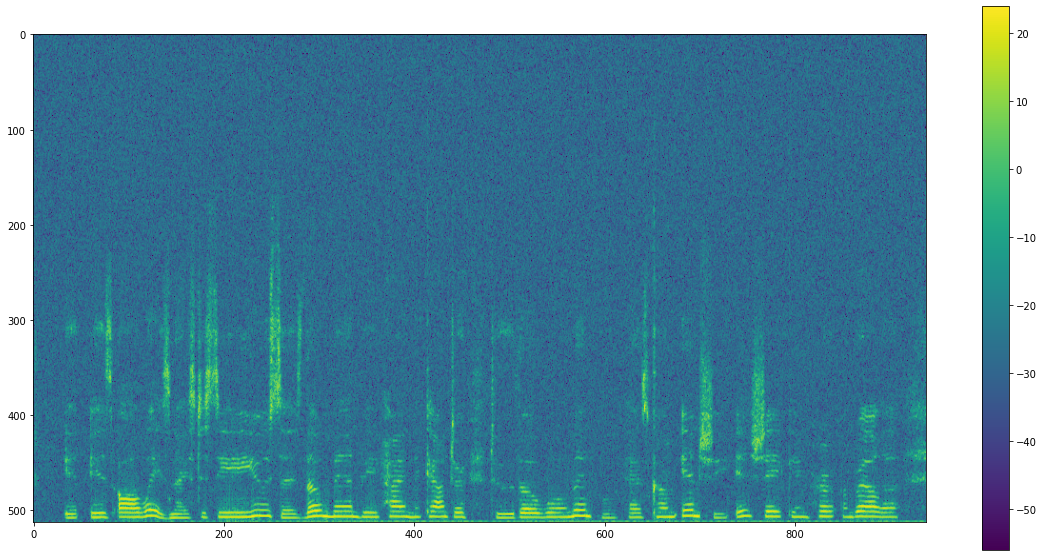

In [17]:
# for wave in wavpath:
wave = wavpath[0]
bach_audio = AudioFile(wave)
shape = bach_audio.get_shape()

dataloader = DataLoader(bach_audio, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

model_input, ground_truth, audio_siren = model_input.type(torch.float64), \
                                        ground_truth.type(torch.float64), \
                                         audio_siren.type(torch.float64)
audio = torchaudio.load(os.path.join(datapath, 'mse_stft_recons' + os.path.basename(wave)))[0]
spectrogram(audio)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:17<00:00, 10.12it/s, loss=-12]


2.8721835613250732 1.2953084707260132 1.9059704184532165
[1.6749675273895264, 2.8721835613250732, 2.133657455444336, 2.393801689147949, 2.3399364948272705, 1.500340223312378, 1.2953084707260132, 2.695716381072998, 1.563029408454895, 1.633577585220337, 1.6363027095794678, 1.5946106910705566, 2.166919708251953, 2.1598923206329346, 1.7403110265731812, 1.5343694686889648, 1.6148052215576172, 1.8261014223098755, 1.6011929512023926, 2.1423840522766113]


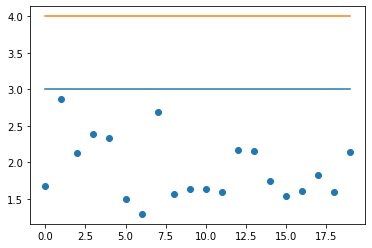

In [2]:

import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader, Dataset
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from asteroid.metrics import get_metrics
from asteroid.losses import singlesrc_neg_sisdr, singlesrc_neg_snr

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from IPython.display import Audio
from tqdm import tqdm
import time



def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple([torch.linspace(-1, 1, steps=sidelen[0])] + [torch.linspace(-1, 1, steps=sidelen[1])])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid
    
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = {}

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations


class AudioFile(torch.utils.data.Dataset):
    def __init__(self, filename):
        self.data, self.rate = torchaudio.load(filename)
        self.data = self.data.transpose(-1,-2).numpy()[...,0]
        self.data = torch.from_numpy(self.data.astype(np.float32))
        self.data = torch.stft(self.data, 1024, return_complex=False)
        self.shape = self.data.shape[:2]
        self.timepoints = get_mgrid(self.shape, 2)
    
    def get_shape(self):
        return self.shape
    
    def get_num_samples(self):
        return self.timepoints.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.timepoints, self.data
    
def reconstruct_shape(model_output, shape):
    return model_output.view([*shape] + [2]).unsqueeze(0)

    
def spectrogram(wav):
    stft = torchaudio.transforms.Spectrogram(n_fft=1024)(wav)[0]
    stft = torchaudio.transforms.AmplitudeToDB(top_db=80)(stft).numpy()
    stft = stft[::-1]
    fig = plt.figure(figsize=(20,10))
    im = plt.imshow(stft)
    plt.colorbar(im)

# bit = torchaudio.backend.sox_io_backend.info(os.path.join(datapath, 'all_mono.wav')).bits_per_sample
datapath = '/root/bigdatasets/INRcompression'
    
audio, rate = torchaudio.load(os.path.join(datapath, 'all_mono.wav'))
# for idx, i in enumerate(range(0, audio.shape[-1], rate * 10)):
#     torchaudio.save(os.path.join(datapath, f'all_mono_{idx}.wav'), audio[:, i:i+rate*10], sample_rate=rate)

wavpath = sorted(glob(os.path.join(datapath, f'all_mono_*.wav')), key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))
    
    
total_steps = 2000
steps_til_summary = 1000

pesq = []
for wave in wavpath:
    bach_audio = AudioFile(wave)
    shape = bach_audio.get_shape()

    audio_siren = Siren(in_features=2, out_features=2, hidden_features=256, 
                        hidden_layers=3, first_omega_0=3000, outermost_linear=True)
    audio_siren.cuda()
    dataloader = DataLoader(bach_audio, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
    
    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

    model_input, ground_truth, audio_siren = model_input.type(torch.float64), \
                                            ground_truth.type(torch.float64), \
                                             audio_siren.type(torch.float64)
    optim = torch.optim.Adam(lr=1e-4, params=audio_siren.parameters())

    with tqdm(range(total_steps)) as pbar:
        for step in pbar:
            optim.zero_grad()
            model_output, coords = audio_siren(model_input)
            # loss = F.mse_loss(model_output, ground_truth.reshape(1, -1, ground_truth.shape[-1]))
            loss = singlesrc_neg_snr(model_output.reshape(1, -1), ground_truth.reshape(1,-1))
            
            pbar.set_postfix({'loss': loss.item()})
            model_output = model_output.view([1]+[*shape]+[2])
            loss.backward()
            optim.step()
    
    audio_siren.eval()
    with torch.no_grad():
        model_output, _ = audio_siren(model_input)
    model_output = torch.istft(torch.complex(model_output[...,0], model_output[...,1]).view([1]+[*shape]), 1024)
    ground_truth = torch.istft(torch.complex(ground_truth[...,0], ground_truth[...,1]), 1024)
    model_output = model_output.float()
    ground_truth = ground_truth.float()
    torchaudio.save(os.path.join(datapath, 'snr_stft_recons' + os.path.basename(wave)), model_output.squeeze(-1).cpu().float(), sample_rate=rate)
    model_output = torchaudio.functional.resample(model_output.squeeze(-1), rate, 16000).squeeze().cpu()
    model_input = torchaudio.functional.resample(model_input.squeeze(-1), rate, 16000).squeeze().cpu()
    
    # model_output, _ = torchaudio.load(os.path.join(datapath, 'recons' + os.path.basename(wave)))
    model_output = model_output.squeeze().numpy()
    ground_truth = torchaudio.functional.resample(ground_truth.squeeze(-1), rate, 16000).squeeze().cpu()
    pesq.append(get_metrics(model_output, ground_truth.numpy(), model_output, sample_rate=16000, metrics_list=['pesq'])['pesq'])

print(max(pesq), min(pesq), np.mean(pesq))
plt.scatter(np.arange(len(pesq)), pesq)
plt.plot(np.ones_like(pesq) * 3)
plt.plot(np.ones_like(pesq) * 4)
print(pesq)

In [23]:
stftaudio = torch.stft(audio, 1024, return_complex=False)
# gt = torch.stft(ground_truth, 1024, return_complex=False)
stftaudio[...,0] = ground_truth[...,0]
# gt.shape
aa = torch.istft(torch.complex(stftaudio[...,0], stftaudio[...,1]), 1024)
torchaudio.save(os.path.join(datapath, 'gmse_stft_recons' + os.path.basename(wave)), aa, 48000)